In [8]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
import pandas as pd

# Generando datasets para entrenar el modelo

In [39]:
IMAGE_FOLDER='datasets/dataset01/images'
class ImageDataset(Dataset):
	def __init__(self, df, image_folder):
		self.df = df
		self.image_folder = image_folder
		self.unique_images = df['file_name'].unique()
	def __len__(self):
		return len(self.unique_images)

	def __getitem__(self, index):
		image_file = self.unique_images[index]
		image_df = self.df[self.df['file_name'] == image_file]
		image_path = f'{self.image_folder}/{image_file}'
		image = cv2.imread(image_path, 1)[...,::-1] # BGR to RGB
		bboxes = image_df[['xmin', 'ymin', 'xmax', 'ymax']].values
		image_classes = image_df['label'].values
		return image, np.array(bboxes, dtype=np.float32), list(image_classes), image_file
		

## Extraer las regiones propuestas para cada imagen y guradrar en un csv los bbs

In [3]:
import glob
from bs4 import BeautifulSoup
df_cols = ['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax', 'data']
def generate_df(files, data):
  df = pd.DataFrame(columns=df_cols)
  for fpath in files:
    f = open(fpath, "r")
    xml = BeautifulSoup(f, 'xml')
    tag = xml.find_all('filename')
    # Obtain the file name
    file_name = tag[0].getText()
    # Obtain the bounding boxes
    bbs = []
    labels = []
    xml_boxes = xml.find_all('object')
    if len(xml_boxes) <= 0: continue # Do not care for this file

    for box in xml_boxes:
      label = box.find('name').getText()
      xmin = int(box.find('bndbox').find('xmin').getText())
      ymin = int(box.find('bndbox').find('ymin').getText())
      xmax = int(box.find('bndbox').find('xmax').getText())
      ymax = int(box.find('bndbox').find('ymax').getText())
      bbs.append([xmin, ymin, xmax, ymax])
      labels.append(label)
    # Create a row on the dataframe for each row
    rows = []
    for ix, box in enumerate(bbs):
      label = labels[ix]
      xmin,ymin,xmax,ymax = box
      rows.append([file_name, label, xmin,ymin,xmax,ymax, data])

    df = pd.concat([df, pd.DataFrame(rows, columns=df_cols)])
  return df

### Generando dataset para frutas, manzanas y bananas

In [17]:
test_files = glob.glob("images/dataset01/test/*.xml")
train_files = glob.glob("images/dataset01/train/*.xml")
train_df = generate_df(train_files, 'train')
test_df = generate_df(test_files, 'test')
df = pd.concat([train_df,test_df])
# Save df as csv into images/dataset01
df.to_csv('images/dataset01/df.csv', index=False)

df.head()

,file_name,label,xmin,ymin,xmax,ymax,data
0,apple_49.jpg,apple,15,87,255,291,train
0,apple_75.jpg,apple,5,31,287,276,train
0,apple_61.jpg,apple,234,132,416,343,train
0,orange_3.jpg,orange,103,104,224,247,train
1,orange_3.jpg,orange,97,1,203,115,train


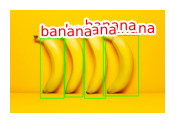

(413, 620, 3)

In [103]:
fruits_df = pd.read_csv('datasets/dataset01/df.csv')
image_ds = ImageDataset(fruits_df, IMAGE_FOLDER)
image, bboxes, classes, image_file = image_ds[4]


show(image, bbs=bboxes, texts=classes, sz=2, text_sz=10)
print(image.shape)

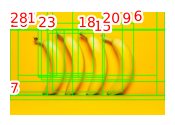

In [117]:
def extract_candidates(img):
  # img - (h,w,3)
  candidates = []
  img_lbl, regions = selectivesearch.selective_search(img, min_size=200,scale=200)
  image_area = np.prod(img.shape[:2])
  for r in regions:
    if r in candidates: continue
    if r['size'] < image_area * 0.05: continue
    if r['size'] > image_area * 1: continue
    candidates.append(list(r['rect']))
  return candidates
candidates = extract_candidates(image)

show(image, bbs=candidates, texts=[f'{i}' for i in range(len(candidates))], sz=2, text_sz=10)

In [118]:
def extract_iou(boxA, boxB, epsilon = 1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  # Intersection area
  width = x2 - x1
  height = y2 - y1
  intersection_area = width * height
  boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  total_area = (boxA_area + boxB_area) - intersection_area
  iou = intersection_area / (total_area + epsilon)
  return iou


In [ ]:
import warnings
warnings.filterwarnings('ignore')
FPATHS, GTBBS, CLSS ,DELTAS, ROIS, IOUS = [], [], [], [], [], []

# For each image on the ds
for ix, (image, bboxes, classes, image_file) in enumerate(image_ds):
	
	H, W, _ = image.shape
	clss, deltas, rois, ious = [], [], [], []
	# 1. Extract the candidates
	candidates = extract_candidates(image)
	# 1.1 Pass the candidates to xmin, ymin, xmax, ymax format
	candidates = np.array([[x,y,x+w,y+h] for (x,y,w,h) in candidates])
	# 2. Extract the IOUS for each candidate and the ground truth bbs the final shape is (len(candidates), len(ground_truth_bbs))
	ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bboxes]).T
	# 3. For each candidate
	for jx, candidate in enumerate(candidates):
		# 3.1 Extract the ious for the candidate
		candidate_ious = ious[jx]
		# 3.2 Extract the coordinates for the candidate
		cx, cy, cX, cY = candidate
		# 3.3 Extract the best iou
		best_iou_idx = np.argmax(candidate_ious)
		best_iou = candidate_ious[best_iou_idx]
		# 3.4 Extract the best iou coordinates
		best_iou_bb = _x, _y, _X, _Y = bboxes[best_iou_idx]
		# 3.5 If the best iou is > 0.3 then the candidate is a positive sample - if not it is background
		if best_iou > 0.3:
			clss.append(classes[best_iou_idx])
		else:
			clss.append('background')
		# 3.6 Extract the deltas for the candidate - divide by the image width and height
		delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
		roi = np.array([cx, cy, cX, cY]) / np.array([W, H, W, H])
		deltas.append(delta)
		rois.append(roi)
		
	# 4. Append image path
	FPATHS.append(image_file)
	# 4. append rois
	ROIS.append(rois)
	# 4. append deltas
	DELTAS.append(deltas)
	# 4. append ious
	IOUS.append(ious)
	# 4. append ground truth bbs
	GTBBS.append(bboxes)
	# 4. append classes
	CLSS.append(clss)
	
	print(f"Parsed {ix}/{len(image_ds)} images")
 

In [204]:
# Save the data to a csv
df = pd.DataFrame(columns=['file_path', 'x', 'y','X','Y', 'dx', 'dy', 'dX', 'dY','class'])
for ix, (fpath, clss, deltas, rois) in enumerate(zip(FPATHS, CLSS, DELTAS, ROIS)):
	# This will run for each image
	for jx, (cls, delta, roi) in enumerate(zip( clss, deltas, rois)):
		
		x, y, X, Y = roi
		dx, dy, dX, dY = delta
		# Create a row
		row = [fpath, x, y, X, Y, dx, dy, dX, dY, cls]
		df.loc[len(df)] = row
		

In [210]:
# Save the dataset
df.to_csv('datasets/dataset01/ds_images.csv', index=False)


In [215]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [224]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # why these numbers
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)  # h, w, c - c, h, w
  img = normalize(img)
  return img.to(device).float()
def decode(_y):
  _, preds = _y.max(-1)
  return preds

class RCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas):
    self.fpaths = fpaths
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image_path = f'{IMAGE_FOLDER}/{fpath}'
    image = cv2.imread(image_path, 1)[...,::-1]
    H,W,_ = image.shape
    sh = np.array([W,H,W,H])
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    return image, crops, bbs, labels, deltas, fpath

  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for ix in range(len(batch)):
      image,crops,image_bbs,image_labels,image_deltas,image_fpath = batch[ix]
      crops = [cv2.resize(crop, (244,244)) for crop in crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas

In [225]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train],DELTAS[:n_train],)
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:],DELTAS[n_train:],)

In [226]:
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [220]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
  param.requires_grad = False
vgg_backbone.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/guillermosantosbarrios/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:56<00:00, 9.74MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [227]:
import torch.nn as nn

class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 25088
    self.backbone = vgg_backbone
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512,4),
        nn.Tanh()
    )
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()
  def forward(self, input):
    feat = self.backbone(input)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cel(probs, labels)
    ixs, = torch.where(labels != 0)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas, deltas)
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

def train_batch(inputs, model, optimizer, criterion):
  input,clss,deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(input)
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [228]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    loss, loc_loss, regr_loss, accs = train_batch(inputs,rcnn,optimizer,criterion)
    pos = (epoch + (ix + 1) /_n)
    log.record(pos, trn_loss=loss.item(),trn_loc_loss=loc_loss, trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')
  _n = len(test_loader)

  for ix, inputs in enumerate(test_loader):
    _clss, _deltas, _loss, loc_loss, regr_loss, accs = validate_batch(inputs,rcnn,criterion)
    pos = (epoch + (ix + 1) /_n)
    log.record(pos, val_loss=loss.item(),val_loc_loss=loc_loss,val_regr_loss=regr_loss,val_acc=accs.mean(),end='\r')

EPOCH: 0.319  trn_loss: 2.692  trn_loc_loss: 0.672  trn_regr_loss: 0.202  trn_acc: 0.778  (275.37s - 4047.25s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 0.430  trn_loss: 2.117  trn_loc_loss: 0.575  trn_regr_loss: 0.154  trn_acc: 0.765  (372.77s - 3965.50s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 0.837  trn_loss: 4.240  trn_loc_loss: 1.787  trn_regr_loss: 0.245  trn_acc: 0.592  (731.94s - 3640.28s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 0.852  trn_loss: 2.392  trn_loc_loss: 1.042  trn_regr_loss: 0.135  trn_acc: 0.765  (743.00s - 3618.11s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 0.800  val_loss: 3.486  val_loc_loss: 0.581  val_regr_loss: 0.366  val_acc: 0.853  (953.34s - 5005.03s remaining))

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 1.319  trn_loss: 1.604  trn_loc_loss: 0.623  trn_regr_loss: 0.098  trn_acc: 0.849  (1238.43s - 3457.85s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 1.430  trn_loss: 1.700  trn_loc_loss: 0.218  trn_regr_loss: 0.148  trn_acc: 0.941  (1342.81s - 3353.55s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 1.837  trn_loss: 2.024  trn_loc_loss: 0.136  trn_regr_loss: 0.189  trn_acc: 0.972  (1712.91s - 2949.25s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 1.852  trn_loss: 1.347  trn_loc_loss: 0.077  trn_regr_loss: 0.127  trn_acc: 1.000  (1724.41s - 2931.49s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 1.800  val_loss: 2.044  val_loc_loss: 0.426  val_regr_loss: 0.325  val_acc: 0.833  (1936.76s - 3443.13s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 2.319  trn_loss: 0.800  trn_loc_loss: 0.097  trn_regr_loss: 0.070  trn_acc: 0.967  (2228.43s - 2577.29s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 2.430  trn_loss: 1.011  trn_loc_loss: 0.066  trn_regr_loss: 0.094  trn_acc: 0.976  (2334.47s - 2469.70s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 2.837  trn_loss: 1.696  trn_loc_loss: 0.070  trn_regr_loss: 0.163  trn_acc: 0.986  (2712.60s - 2068.09s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 2.852  trn_loss: 1.259  trn_loc_loss: 0.049  trn_regr_loss: 0.121  trn_acc: 1.000  (2724.12s - 2051.93s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 2.800  val_loss: 1.362  val_loc_loss: 0.536  val_regr_loss: 0.334  val_acc: 0.735  (2938.27s - 2308.64s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 3.319  trn_loss: 0.676  trn_loc_loss: 0.069  trn_regr_loss: 0.061  trn_acc: 0.983  (3223.28s - 1633.22s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 3.430  trn_loss: 0.938  trn_loc_loss: 0.051  trn_regr_loss: 0.089  trn_acc: 0.976  (3321.44s - 1520.83s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 3.837  trn_loss: 1.361  trn_loc_loss: 0.061  trn_regr_loss: 0.130  trn_acc: 0.986  (3668.07s - 1111.75s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 3.852  trn_loss: 1.168  trn_loc_loss: 0.043  trn_regr_loss: 0.113  trn_acc: 1.000  (3679.01s - 1096.63s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 3.800  val_loss: 0.996  val_loc_loss: 0.650  val_regr_loss: 0.325  val_acc: 0.539  (3879.22s - 1225.02s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 4.319  trn_loss: 0.558  trn_loc_loss: 0.050  trn_regr_loss: 0.051  trn_acc: 0.983  (4152.58s - 655.30s remaining))

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 4.430  trn_loss: 0.805  trn_loc_loss: 0.043  trn_regr_loss: 0.076  trn_acc: 1.000  (4253.81s - 547.73s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 4.837  trn_loss: 1.360  trn_loc_loss: 0.057  trn_regr_loss: 0.130  trn_acc: 0.986  (4627.71s - 155.91s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 4.852  trn_loss: 0.938  trn_loc_loss: 0.036  trn_regr_loss: 0.090  trn_acc: 1.000  (4639.11s - 141.65s remaining)

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 4.800  val_loss: 0.786  val_loc_loss: 0.958  val_regr_loss: 0.324  val_acc: 0.539  (4852.91s - 202.20s remaining))

libpng warning: iCCP: known incorrect sRGB profile


EPOCH: 5.000  val_loss: 0.786  val_loc_loss: 0.038  val_regr_loss: 0.097  val_acc: 1.000  (4866.09s - 0.00s remaining)))

100%|██████████| 106/106 [00:00<00:00, 15755.21it/s]


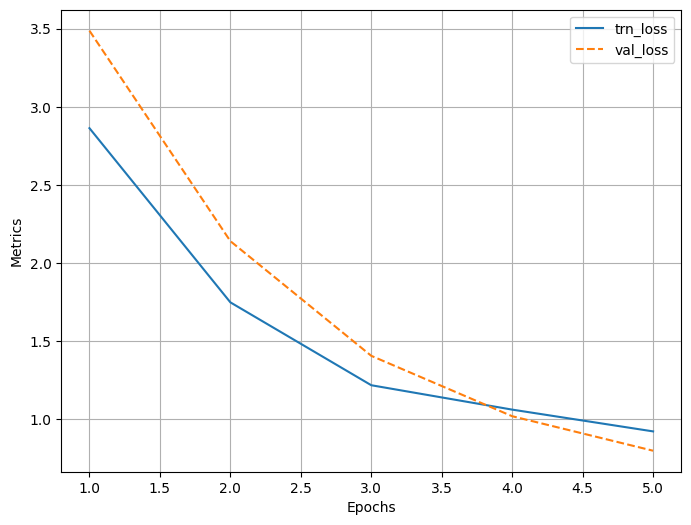

In [229]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [253]:
def test_predictions(filename, show_output=True):
    file_path = f'{IMAGE_FOLDER}/{filename}'
    img = np.array(cv2.imread(file_path, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class', text_sz=10)
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

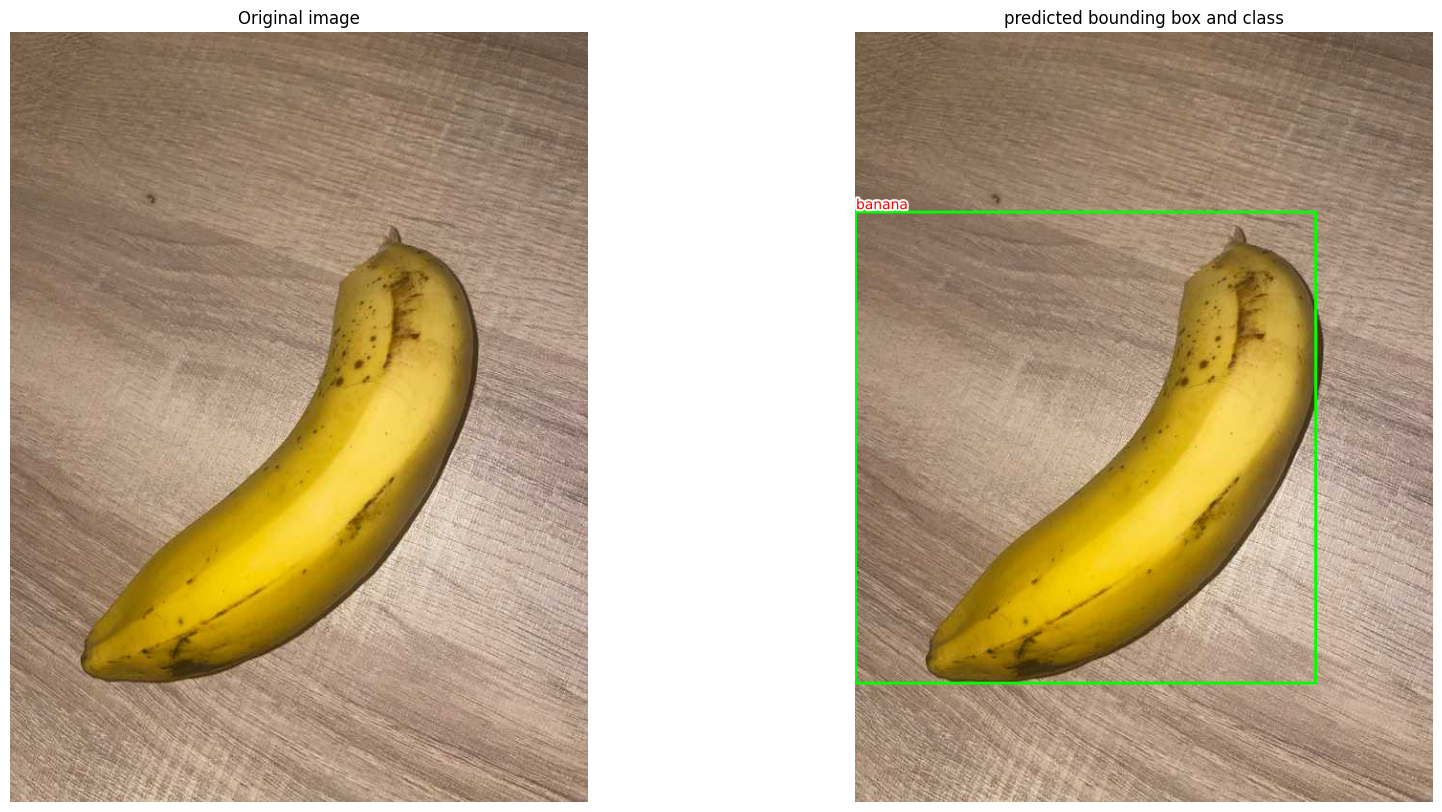

((0, 188, 481, 681), 'banana', 0.9999937)

In [263]:
image, crops, bbs, labels, deltas, fpath = test_ds[12]
test_predictions('banana_test.jpg')

In [266]:
# Save model
torch.save(rcnn.state_dict(), 'models/rcnn_00.pt')